In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 36.1MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import pickle
from konlpy.tag import Okt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import numpy as np


#LSTM훈련된 모델을 통한 긍부정 평가

def sentiment_predict(new_sentence):
    caption_pattern = re.compile('^ {10,}.*$')
    invalid_pattern = re.compile('(재?배포.* ?금지|\w+@\w+\.▲[a-z]+|(기자|영상편집):|제보를 기다립니다|Copyright 한국경제티브이|All rights reserved.|추천 (기사|칼럼)|사진=)')
    okt = Okt()
    sent_model = load_model('/content/drive/MyDrive/DART_project/LSTM훈련용 Dataset/best_model.h5')
    with open("/content/drive/MyDrive/DART_project/LSTM훈련용 Dataset/tokenizer.pickle", "rb") as handle:
        sent_tokenizer = pickle.load(handle)
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    for i in range(len(new_sentence)):
      temp_X = [] 
      temp_X = okt.morphs(new_sentence.제목[i], stem=True) # 토큰화 
      temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
      new_sentence.제목[i] = temp_X
    print(new_sentence.제목)
    
    encoded = sent_tokenizer.texts_to_sequences(new_sentence.제목) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 20) # 패딩
    
    predict = sent_model.predict(pad_new) # 예측
    predict_labels = np.argmax(predict, axis=1)
    for i in range(len(predict_labels)):
      if predict_labels[i] == 2:
        predict_labels[i] = 1
      elif predict_labels[i] == 1:
        predict_labels[i] = 0
      elif predict_labels[i] == 0:
        predict_labels[i] = -1 
    return predict_labels

In [ ]:
#단어사전을통한 키워드 분석

def positive_negitive_score(data):
  positive_negitive = pd.read_excel('/content/drive/MyDrive/DART_project/긍부정 단어 사전(수정).xlsx')
  positive = positive_negitive.긍정
  negitive = positive_negitive.부정
  positive= positive.dropna()
  positive_words = []
  negitive_words = []
  for i in positive:
    positive_words.append(i)
  for i in negitive:
    negitive_words.append(i)
    
  score_list =[]
  positive_list= []
  negitive_list = []
  
  for data_index in range(len(data)):
    positive_count = 0
    negitive_count = 0
    total_score = 0
    
  
    keyword_list = data.키워드[data_index].split(',')
    for n in range(len(keyword_list)):
      if n == len(keyword_list)-1:
        if keyword_list[n] in positive_words:
          positive_count =positive_count+ 1
          positive_list.append(positive_count)
          negitive_list.append(negitive_count)
          
          
          
          # total_score = positive_count/(positive_count+negitive_count)
          # score_list.append(total_score)
        elif keyword_list[n] in negitive_words:
          negitive_count =negitive_count+1
          # total_score = positive_count/(positive_count+negitive_count)
          # score_list.append(total_score)
          
          negitive_list.append(negitive_count) 
          positive_list.append(positive_count)
                                              
                                        
        else: 
          negitive_list.append(negitive_count)
          positive_list.append(positive_count)
          # total_score = (positive_count)/(positive_count+negitive_count)
          # score_list.append(total_score)


      else:
        if keyword_list[n] in positive_words:
          positive_count = positive_count+1
        elif keyword_list[n] in negitive_words:
          negitive_count = negitive_count+1
        else: 
          continue
  

  total = []
  list1 = []
  for i in range(len(negitive_list)):
    difference = positive_list[i] - negitive_list[i]
    total.append(difference)
    if (negitive_list[i] != 0)&(positive_list[i] != 0) &(difference ==0):
      list1.append(i)
  data['긍정키워드갯수-부정'] = total
  aggregations = {
    
      '기사갯수':'sum',
      '긍정키워드갯수-부정':'max',
      '0-2 긍부정 label':'mean',
  }
  data = data.groupby(['일자','name']).agg(aggregations)
  data = data.reset_index()
  return data      


In [ ]:
#날짜 공백 메우기 및 timedelta생성

def fill_date(data):
  date_list = pd.read_excel('/content/drive/MyDrive/DART_project/LSTM훈련용 Dataset/날짜data.xlsx')
  time_list=[]
  for i in range(len(date_list)):
    date_list.일자[i] = datetime.strftime(date_list.일자[i],'%Y-%m-%d')
  for i in range(len(data)):
    data.일자[i]= pd.to_datetime(str(data.일자[i]),format='%Y/%m/%d')
    data.일자[i]= datetime.strftime(data.일자[i],'%Y-%m-%d')
  data = date_list.merge(data,how='outer',on='일자')
  data.name = data.name.fillna(company)


  for i in range(len(data)):
    a= pd.to_datetime(data.일자[i],format='%Y/%m/%d')- datetime.strptime('2018-01-01','%Y-%m-%d')
    k = int(str(a).split(' ')[0])
    time_list.append(k)
  data['timedelta'] = time_list
  data = data.fillna(0)
  
  data = data.reset_index()
  data.drop('index',axis=1,inplace=True)
  week = []
  days = []
  for i in range(len(data)):
    if data.timedelta[i]>=0:
      week.append(data.timedelta[i]//7)
      days.append(data.timedelta[i]%7)
    else:
      week.append((abs(data.timedelta[i])//7))
      days.append(abs(data.timedelta[i])%7)
  week_day = []
  for i in range(len(week)):
    if data.timedelta[i]>=0:
      week_day.append(float(str(week[i])+'.'+str(days[i])))
    else:
      week_day.append(float('-'+str(week[i])+'.'+str(days[i])))

  data['week_day'] = week_day
  data
  #day = 0은 월요일 
  return data



In [ ]:
#1주차, 2주차, 3주차, 4주차 키워드분석, 제목분석, 기사갯수 카운트 변수 생성

def new_columns(data1):
  week1_키워드_list = []
  week2_키워드_list = []
  week3_키워드_list = []
  week4_키워드_list = []
  week1_긍부정_list = []
  week2_긍부정_list = []
  week3_긍부정_list = []
  week4_긍부정_list = []
  week1_기사개수_list = []
  week2_기사개수_list = []
  week3_기사개수_list = []
  week4_기사개수_list = []
  

  month_기사개수_list = []

  for i in range(len(data1)):
    

    
    if data1.timedelta[i] < 0:
      continue
    else :
      week1_키워드 = []
      week1_긍부정 = []
      week1_기사개수 = 0
      week2_키워드 = []
      week2_긍부정 = []
      week2_기사개수 = 0
      week3_키워드 = []
      week3_긍부정 = []
      week3_기사개수 = 0
      week4_키워드 = []
      week4_긍부정 = []
      week4_기사개수 = 0
      month_키워드 = []
      month_긍부정 = []
      month_기사개수 = 0
      week_current = 1 #비교용
      
      
      for k in range(i-len(week1_키워드)):
        
        if data1.timedelta[i]- data1.timedelta[i-1-k] <= 7:      
            week1_키워드.append(data1['긍정키워드갯수-부정'][i-1-k])
            week1_긍부정.append(data1['0-2 긍부정 label'][i-1-k])
            week1_기사개수 = week1_기사개수 + data1['기사갯수'][i-1-k]           
        elif (data1.timedelta[i] - data1.timedelta[i-1-k] >7)&(data1.timedelta[i] - data1.timedelta[i-1-k] <=14):
            week2_키워드.append(data1['긍정키워드갯수-부정'][i-1-k])
            week2_긍부정.append(data1['0-2 긍부정 label'][i-1-k])
            week2_기사개수 = week2_기사개수 + data1['기사갯수'][i-1-k] 
        elif (data1.timedelta[i] - data1.timedelta[i-1-k] >14)&(data1.timedelta[i] - data1.timedelta[i-1-k] <=21):
            week3_키워드.append(data1['긍정키워드갯수-부정'][i-1-k])
            week3_긍부정.append(data1['0-2 긍부정 label'][i-1-k])
            week3_기사개수 = week3_기사개수 + data1['기사갯수'][i-1-k]          
        elif (data1.timedelta[i] - data1.timedelta[i-1-k] >21)&(data1.timedelta[i] - data1.timedelta[i-1-k] <=28):        
            week4_키워드.append(data1['긍정키워드갯수-부정'][i-1-k])
            week4_긍부정.append(data1['0-2 긍부정 label'][i-1-k])
            week4_기사개수 = week4_기사개수 + data1['기사갯수'][i-1-k]
        else:
          continue
            
      week1_긍부정_list.append(np.mean(week1_긍부정))
      week1_기사개수_list.append(week1_기사개수)
      week1_키워드_list.append(np.mean(week1_키워드))
      week2_긍부정_list.append(np.mean(week2_긍부정))
      week2_기사개수_list.append(week2_기사개수)
      week2_키워드_list.append(np.mean(week2_키워드))
      week3_긍부정_list.append(np.mean(week3_긍부정))
      week3_기사개수_list.append(week3_기사개수)
      week3_키워드_list.append(np.mean(week3_키워드))
      week4_긍부정_list.append(np.mean(week4_긍부정))
      week4_기사개수_list.append(week4_기사개수)
      week4_키워드_list.append(np.mean(week4_키워드))  
  

  for i in range(len(week4_키워드_list)):
    month_기사개수_list.append(week1_기사개수_list[i]+week2_기사개수_list[i]+week3_기사개수_list[i]+week4_기사개수_list[i])  

  data2 = data1[data1.timedelta>=0]
  data2['week1_기사_키워드평균'] = week1_키워드_list
  data2['week1_기사_긍부정평균'] = week1_긍부정_list
  data2['week1_기사_count'] = week1_기사개수_list
  data2['week2_기사_키워드평균'] = week2_키워드_list
  data2['week2_기사_긍부정평균'] = week2_긍부정_list
  data2['week2_기사_count'] = week2_기사개수_list
  data2['week3_기사_키워드평균'] = week3_키워드_list
  data2['week3_기사_긍부정평균'] = week3_긍부정_list
  data2['week3_기사_count'] = week3_기사개수_list
  data2['week4_기사_키워드평균'] = week4_키워드_list
  data2['week4_기사_긍부정평균'] = week4_긍부정_list
  data2['week4_기사_count'] = week4_기사개수_list
  data2['month_기사_count'] = month_기사개수_list
  data2 = data2.fillna(0)
  data2 = data2.reset_index()
  data2.drop('index',axis=1,inplace=True)
  return data2
  

In [ ]:
#기업리스트적용
# list1 = ['삼부토건', '진양화학', '조선선재', '하이스틸', '삼화전기', 'KH필룩스', '대우조선해양', '극동유화', '세이브존I&C', '서울가스', '미창석유', '대성산업','한미약품', '동화약품', '유니퀘스트', '이월드', '삼아알미늄', '조선내화', '일진머티리얼즈', '써니전자', '세방', '현대위아', '계양전기',\
#          '현대건설','대한항공','현대제철','삼성전자','셀트리온','카카오','NAVER','삼성바이오로직스','삼성SDI','호텔신라','한국조선해양','고려아연','S-Oil','POSCO',\
# 'LG이노텍','롯데케미칼','한국전력','롯데쇼핑','기업은행','KT','한국가스공사','한전KPS','GS건설','현대글로비스','SK이노베이션','CJ제일제당','LG화학'] #기업 갯수
list1 = ['유성기업','태영건설','광주신세계','롯데정밀화학']
from datetime import timedelta, datetime
from sklearn import preprocessing
import pandas as pd
data = pd.DataFrame()
import os
import re
score_list = []
import pandas as pd
files = os.listdir('/content/drive/MyDrive/DART_project/기업')

print(files)

for company in list1 :
  score_list=[]
  df = pd.read_excel('/content/drive/MyDrive/DART_project/기업/{}.xlsx'.format(company))  #크롤링 한 파일
  df = df[['일자','제목','키워드']]
  for i in range(len(df)):
    
    new_sentence = 0
    new_sentence = re.sub('[↓▼]', '하락',df.제목[i])
    new_sentence = re.sub('[\-.+%]', '하락',df.제목[i])
    new_sentence = re.sub('[↑▲]', '상승',new_sentence)
    new_sentence = re.sub('[\+.+]', '상승',new_sentence)
    new_sentence = re.sub('[→]', '에서',new_sentence)
    new_sentence = re.sub(r'\[.+\]','', new_sentence)
    new_sentence = re.sub(r'[\,\'\[\]\"]','',new_sentence)
    df.제목[i] = new_sentence
  df['0-2 긍부정 label'] = sentiment_predict(df)
  df['name'] = company
  df['기사갯수'] = 1
  df = positive_negitive_score(df)
  df = fill_date(df)
  df = new_columns(df)
  # data2.drop(['긍정키워드갯수-부정','기사갯수','week_day','timedelta','0-2 긍부정 label'],axis=1,inplace=True)
  data = data.append(df)
  print(company)
data =  data.reset_index()
data.drop(['index','timedelta','week_day','기사갯수','긍정키워드갯수-부정',	'0-2 긍부정 label'],axis=1,inplace=True)

  

['GS건설.xlsx', 'LG화학.xlsx', '현대제철.xlsx', '삼성SDI.xlsx', '호텔신라.xlsx', '고려아연.xlsx', 'S-Oil.xlsx', 'LG이노텍.xlsx', '롯데케미칼.xlsx', '현대건설.xlsx', '한국전력.xlsx', '롯데쇼핑.xlsx', '기업은행.xlsx', 'KT.xlsx', '한국가스공사.xlsx', '한전KPS.xlsx', '현대글로비스.xlsx', 'SK이노베이션.xlsx', 'CJ제일제당.xlsx', '대한항공.xlsx', '삼성전자.xlsx', '한국조선해양.xlsx', '.ipynb_checkpoints', 'POSCO.xlsx', '셀트리온.xlsx', 'NAVER.xlsx', '카카오.xlsx', '삼성바이오로직스.xlsx', '삼부토건.xlsx', '진양화학.xlsx', '조선선재.xlsx', '하이스틸.xlsx', '삼화전기.xlsx', 'KH필룩스.xlsx', '대우조선해양.xlsx', '극동유화.xlsx', 'BGF.xlsx', '서울가스.xlsx', '미창석유.xlsx', '한미약품.xlsx', '동화약품.xlsx', '이월드.xlsx', '삼아알미늄.xlsx', '조선내화.xlsx', '일진머티리얼즈.xlsx', '써니전자.xlsx', '세방.xlsx', '현대위아.xlsx', '계양전기.xlsx', '대성산업.xlsx', '유니퀘스트.xlsx', '세이브존I&C.xlsx', '광주ᄉ

In [ ]:
import pickle
with open('/content/drive/MyDrive/DART_project/기사/다담았다.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/DART_project/기사/다담았다.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
#정량데이터셋 불러오기
!pip install pickle5
import pickle5
with open('/content/drive/MyDrive/DART_project/dataset/result_qadf_v053004.pkl','rb') as f:
  result = pickle5.load(f)

In [ ]:
result = result.append(aaaa)

In [ ]:
result = result[result.DATE>='2018-01-01']
result = result.reset_index()
result.drop('index',axis=1,inplace=True)

In [ ]:
#label만들기

def create_timedelta(df):

  #timedelta생성
  from datetime import timedelta, datetime
  time_list = []
  for i in range(len(df)):
    k = pd.to_datetime(df.DATE[i])- datetime.strptime('2018-01-01','%Y-%m-%d')
    time_list.append(int(str(k).split(' ')[0]))
  df['timedelta'] = time_list

  #labe생성
  label = []
  for i in range(len(df)-20):  #20만큼의 차이를 준 이유는 4주차뒤까지 확인을 해보기 위함
    max_timedelta = 0 
    row = 0
    for k in range(21):
      
      if (df.timedelta[i+k]-df.timedelta[i] >=21)&(df.timedelta[i+k]-df.timedelta[i]<=28):
        if max_timedelta < df.timedelta[i+k]:
          max_timedelta = df.timedelta[i+k]
          row = i+k
      else:
        continue
    label.append((df.CLOSE[row] -df.CLOSE[i])/df.CLOSE[i])
  for i in range(20): #20번 0추가
    label.append(0)
  df['label'] = label
  df.drop('timedelta',axis=1,inplace=True)
  df = df.set_index('label')
  df = df.reset_index()
  return df


In [ ]:
result1 =  create_timedelta(result)
result1= result1[result1.DATE <= '2020.12.31']
result1 = result.reset_index()
result1.drop('index',axis=1,inplace=True)

,label,DATE,NAME,SECTOR,OPEN,HIGH,LOW,CLOSE,VOLUME,1M_CLOSE_STD,PER,PBR,EPS,BPS,DIV,DPS,CAPITALIZATION,NUMB_OF_SHARES,INSTITUTION(NP),CORP(NP),INDIVIDUAL(NP),FOREIGN(NP),ASST_INC,REV_INC,PROF_INC,S_ASST_INC,REV_BPR,EQ_NPR,RA_BPR,R_RATIO,D_RATIO,F_RATIO,DEBT_R,ASST_TO,SA_C_TO,ST_TO,MA5,MA10,MA20,MA50,ADX,CCI,WILLR,RSI
0,0.168237,2018-01-02,현대건설,건설,36450,37400,36100,37150,649218,729.692760,8.44,0.65,4403,56944,1.35,500,4136866669750,111355765,9961402750,-40027350,-10690380200,769004800,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,35810.0,35875.0,35622.50,36807.0,12.044274,153.318078,-8.620690,57.307471
1,0.181818,2018-01-03,현대건설,건설,36650,37000,36200,36300,482518,724.305702,8.24,0.64,4403,56944,1.38,500,4042214269500,111355765,-595877500,126433500,6382336100,-5912892100,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,36090.0,35905.0,35702.50,36745.0,12.183271,92.292089,-37.931034,52.062683
2,0.163373,2018-01-04,현대건설,건설,36300,38400,36300,37950,1459930,853.650292,8.62,0.67,4403,56944,1.32,500,4225951281750,111355765,22323833700,-583961200,-20026334100,-1713538400,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,36610.0,36070.0,35832.50,36703.0,13.522327,206.194190,-11.538462,59.761265
3,0.141919,2018-01-05,현대건설,건설,38200,38600,37300,38050,655891,970.138032,8.64,0.67,4403,56944,1.31,500,4237086858250,111355765,7110992800,98846200,359918900,-7569757900,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,37150.0,36295.0,35897.50,36663.0,14.910828,188.419405,-13.414634,60.178666
4,0.132986,2018-01-08,현대건설,건설,38000,38550,37400,38350,577188,1136.080398,8.71,0.67,4403,56944,1.30,500,4270493587750,111355765,1486355000,-32587400,-2896717650,1442950050,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,37560.0,36520.0,36012.50,36630.0,16.200150,153.724271,-6.097561,61.469930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,0.210811,2020-12-23,유성기업,자동차부품,2760,2805,2745,2775,118731,NaN,4.09,0.26,678,10636,7.21,200,72004312500,25947500,24995,-4496365,89867890,-85396520,-0.928216,-22.973962,-143.353758,392.645887,-7.895938,-0.555038,-2.344273,495.870389,382.217629,63.454242,29.419213,0.156352,1.46466,1.034136,2774.0,2765.5,2777.50,2787.6,21.724390,56.697819,-59.259259,48.687474
41086,0.159574,2020-12-24,유성기업,자동차부품,2780,2845,2775,2820,223081,NaN,4.16,0.27,678,10636,7.09,200,73171950000,25947500,-1201750,-134880,10005235,-8668605,-0.928216,-22.973962,-143.353758,392.645887,-7.895938,-0.555038,-2.344273,495.870389,382.217629,63.454242,29.419213,0.156352,1.46466,1.034136,2784.0,2773.0,2778.50,2789.0,23.115279,248.484848,-20.000000,56.774687
41087,0.190731,2020-12-28,유성기업,자동차부품,2835,2845,2780,2805,164408,NaN,4.14,0.26,678,10636,7.13,200,72782737500,25947500,-451560,7012500,101771540,-108332480,-0.928216,-22.973962,-143.353758,392.645887,-7.895938,-0.555038,-2.344273,495.870389,382.217629,63.454242,29.419213,0.156352,1.46466,1.034136,2791.0,2778.0,2778.25,2791.5,24.406820,173.305671,-32.000000,53.734554
41088,0.220000,2020-12-29,유성기업,자동차부품,2760,2775,2615,2750,141452,NaN,4.06,0.26,678,10636,7.27,200,71355625000,25947500,-589245,0,29317220,-28727975,-0.928216,-22.973962,-143.353758,392.645887,-7.895938,-0.555038,-2.344273,495.870389,382.217629,63.454242,29.419213,0.156352,1.46466,1.034136,2782.0,2776.5,2775.25,2792.8,24.192811,-190.869293,-41.304348,44.355814


In [ ]:
import pickle
with open('/content/drive/MyDrive/DART_project/기사/다담았다.pkl', 'rb') as f:
  data = pickle.load(f)

In [ ]:
a = result1.NAME.value_counts().reset_index()
b = data.NAME.value_counts().reset_index()
a.merge(b,how='outer',on=['index'])
# KH필룩스, 셀트리온, 기업은행이 안맞음

,index,NAME_x,NAME_y
0,세방,738.0,1096.0
1,S-Oil,738.0,1096.0
2,GS건설,738.0,1096.0
3,호텔신라,738.0,1096.0
4,고려아연,738.0,1096.0
5,현대제철,738.0,1096.0
6,동화약품,738.0,1096.0
7,미창석유,738.0,1096.0
8,조선내화,738.0,1096.0
9,한국전력,738.0,1096.0


In [ ]:
#정량, 정성적 변수합치기
data = data.rename({'일자':'DATE','name':'NAME'},axis=1)
data.NAME[data.NAME =='KH필룩스'] = 'KH 필룩스'
final_df = result1.merge(data,how='inner',on=['DATE','NAME'])

In [ ]:
for i in range(len(final_df)):
  if final_df['label'][i]>= 0.1 :
    final_df['label'][i] == 2
  elif final_df['label'][i] >=0:
    final_df['label'][i] ==1
  elif final_df['label'][i] <0:
    final_df['label'][i] == 0

In [ ]:
final_df

,DATE,NAME,SECTOR,OPEN,HIGH,LOW,CLOSE,VOLUME,1M_CLOSE_STD,PER,PBR,EPS,BPS,DIV,DPS,CAPITALIZATION,NUMB_OF_SHARES,INSTITUTION(NP),CORP(NP),INDIVIDUAL(NP),FOREIGN(NP),ASST_INC,REV_INC,PROF_INC,S_ASST_INC,REV_BPR,EQ_NPR,RA_BPR,R_RATIO,D_RATIO,F_RATIO,DEBT_R,ASST_TO,SA_C_TO,ST_TO,MA5,MA10,MA20,MA50,ADX,CCI,WILLR,RSI,label,week1_기사_키워드평균,week1_기사_긍부정평균,week1_기사_count,week2_기사_키워드평균,week2_기사_긍부정평균,week2_기사_count,week3_기사_키워드평균,week3_기사_긍부정평균,week3_기사_count,week4_기사_키워드평균,week4_기사_긍부정평균,week4_기사_count,month_기사_count
0,2018-01-02,현대건설,건설,36450,37400,36100,37150,649218,729.692760,8.44,0.65,4403,56944,1.35,500,4136866669750,111355765,9961402750,-40027350,-10690380200,769004800,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,35810.0,35875.0,35622.50,36807.0,12.044274,153.318078,-8.620690,57.307471,0.168237,3.000000,-0.014610,21.0,5.000000,0.250000,14.0,15.714286,0.005952,23.0,1.714286,-0.333333,12.0,70.0
1,2018-01-03,현대건설,건설,36650,37000,36200,36300,482518,724.305702,8.24,0.64,4403,56944,1.38,500,4042214269500,111355765,-595877500,126433500,6382336100,-5912892100,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,36090.0,35905.0,35702.50,36745.0,12.183271,92.292089,-37.931034,52.062683,0.181818,3.571429,0.021104,25.0,3.571429,0.107143,10.0,12.285714,0.053571,21.0,5.428571,-0.309524,16.0,72.0
2,2018-01-04,현대건설,건설,36300,38400,36300,37950,1459930,853.650292,8.62,0.67,4403,56944,1.32,500,4225951281750,111355765,22323833700,-583961200,-20026334100,-1713538400,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,36610.0,36070.0,35832.50,36703.0,13.522327,206.194190,-11.538462,59.761265,0.163373,5.142857,-0.017161,24.0,3.142857,0.089286,14.0,8.857143,0.107143,17.0,8.571429,-0.208333,18.0,73.0
3,2018-01-05,현대건설,건설,38200,38600,37300,38050,655891,970.138032,8.64,0.67,4403,56944,1.31,500,4237086858250,111355765,7110992800,98846200,359918900,-7569757900,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,37150.0,36295.0,35897.50,36663.0,14.910828,188.419405,-13.414634,60.178666,0.141919,4.714286,-0.198980,16.0,4.142857,0.128247,25.0,6.285714,0.250000,16.0,13.285714,-0.208333,17.0,74.0
4,2018-01-08,현대건설,건설,38000,38550,37400,38350,577188,1136.080398,8.71,0.67,4403,56944,1.30,500,4270493587750,111355765,1486355000,-32587400,-2896717650,1442950050,-1.153340,0.833140,-45.706440,99.771391,6.623698,1.321848,4.555767,181.696276,156.468083,59.791628,123.003899,0.504743,1.76932,2.227292,37560.0,36520.0,36012.50,36630.0,16.200150,153.724271,-6.097561,61.469930,0.132986,4.428571,-0.096939,23.0,3.000000,-0.014610,21.0,6.000000,0.392857,16.0,14.714286,-0.279762,22.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39261,2021-02-22,유성기업,자동차부품,3235,3255,3215,3215,86083,NaN,4.74,0.30,678,10636,6.22,200,83421212500,25947500,-125805,0,842970,-717165,2.127193,25.815073,-101.095903,539.359417,-3.572425,0.006085,-1.439758,433.468634,338.702843,68.749210,32.218547,0.196783,1.60166,1.418175,3283.0,3339.0,3302.75,3055.4,43.202944,-65.883275,-70.053476,49.177757,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
39262,2021-02-23,유성기업,자동차부품,3185,3215,3135,3150,121527,NaN,4.65,0.30,678,10636,6.35,200,81734625000,25947500,860830,0,-7984250,7123420,2.127193,25.815073,-101.095903,539.359417,-3.572425,0.006085,-1.439758,433.468634,338.702843,68.749210,32.218547,0.196783,1.60166,1.418175,3253.0,3305.0,3288.50,3063.6,41.352976,-126.430756,-89.440994,46.020285,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0000

In [ ]:
#1차 상관관계 확인
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
class_le = LabelEncoder()
final_df.SECTOR = class_le.fit_transform(final_df['SECTOR'].values)

ad=final_df.corr()
ad.style.background_gradient(cmap='coolwarm')

#Volume이 다른변수와 상관관계가 높으므로 CLOSE와 변수를 만들 예정
# PER, PERSECTOR중 SECTOR가 종속변수에 영향을 많이 미침
#PBR, PBRSECTOR중 PBRSECOTR가 더 좋음 
#EPS, DPS, BPS -> DPS선택
#PER,PBR MARKET - > PBR MARKET선택


In [ ]:
final_df1 = final_df.drop(['INDIVIDUAL(NP)','CAPITALIZATION','CLOSE','OPEN','HIGH','LOW','BPS','EPS','NUMB_OF_SHARES','DEBT_R','MA10','MA20','MA50','WILLR','RSI','1M_CLOSE_STD'],axis=1)
ad=final_df1.corr()
ad.style.background_gradient(cmap='coolwarm')


,SECTOR,VOLUME,PER,PBR,DIV,DPS,INSTITUTION(NP),CORP(NP),FOREIGN(NP),ASST_INC,REV_INC,PROF_INC,S_ASST_INC,REV_BPR,EQ_NPR,RA_BPR,R_RATIO,D_RATIO,F_RATIO,ASST_TO,ST_TO,MA5,ADX,CCI,label,week1_기사_키워드평균,week1_기사_긍부정평균,week1_기사_count,week2_기사_키워드평균,week2_기사_긍부정평균,week2_기사_count,week3_기사_키워드평균,week3_기사_긍부정평균,week3_기사_count,week4_기사_키워드평균,week4_기사_긍부정평균,week4_기사_count,month_기사_count
SECTOR,1.000000,-0.069711,-0.047414,0.210885,-0.180688,0.057750,0.011010,-0.027764,0.011073,0.056531,0.026731,0.083690,0.135578,-0.062551,-0.005423,-0.071649,0.038886,0.077601,0.071122,-0.017952,-0.086765,0.232541,0.019213,0.009799,0.002630,-0.095292,-0.162932,-0.136785,-0.094717,-0.160518,-0.135786,-0.096062,-0.162820,-0.136429,-0.096582,-0.161420,-0.137066,-0.150619
VOLUME,-0.069711,1.000000,-0.006142,0.053595,-0.050116,-0.068698,-0.074156,-0.005938,-0.039839,0.008593,0.003502,0.005466,0.181110,-0.006598,0.000860,-0.020629,0.019484,0.022490,-0.006773,-0.097673,-0.053199,-0.095933,0.069251,0.110433,0.016183,0.308115,0.051327,0.330613,0.297777,0.054228,0.317847,0.292606,0.051997,0.316333,0.290643,0.057931,0.314245,0.352797
PER,-0.047414,-0.006142,1.000000,0.023943,-0.077344,-0.047562,0.000652,-0.003197,0.002387,-0.008404,-0.013061,0.001796,0.009128,-0.006758,-0.002664,-0.011052,-0.019238,-0.000425,-0.000595,-0.048902,-0.022831,-0.022016,0.049005,0.015701,0.009580,-0.012447,-0.018592,-0.017247,-0.011091,-0.011890,-0.016724,-0.009790,-0.016385,-0.016371,-0.010707,-0.013059,-0.016394,-0.018408
PBR,0.210885,0.053595,0.023943,1.000000,-0.365090,-0.128142,-0.012700,0.003357,0.008290,0.105550,0.122014,0.033179,0.065343,0.377376,0.101968,-0.046150,-0.011512,0.035282,-0.064575,-0.122930,-0.094286,0.451779,0.053270,0.062619,-0.026599,0.224230,-0.028004,0.125607,0.224595,-0.030507,0.123452,0.226042,-0.029355,0.124527,0.225316,-0.027246,0.124706,0.137442
DIV,-0.180688,-0.050116,-0.077344,-0.365090,1.000000,0.448866,0.001839,0.046392,-0.018265,-0.043998,-0.044208,-0.073119,-0.014664,-0.101607,0.087929,0.005444,0.109020,-0.151079,-0.132946,0.093588,0.160663,-0.029879,-0.022434,-0.046534,-0.016037,0.002579,0.018365,0.051785,0.002351,0.018708,0.052060,0.002058,0.022315,0.051640,0.004396,0.025944,0.052862,0.057467
DPS,0.057750,-0.068698,-0.047562,-0.128142,0.448866,1.000000,-0.022017,0.170674,-0.046977,0.009031,-0.043775,0.014683,0.189076,-0.029971,0.050963,0.001027,0.122932,-0.198959,-0.109768,-0.075638,-0.024238,0.474287,-0.089098,-0.027077,-0.048563,0.194392,0.011604,0.149482,0.190884,0.014533,0.141977,0.189044,0.016701,0.138278,0.189589,0.017340,0.139924,0.157131
INSTITUTION(NP),0.011010,-0.074156,0.000652,-0.012700,0.001839,-0.022017,1.000000,-0.085938,-0.156133,-0.005110,-0.000773,-0.000283,-0.035759,-0.013260,-0.009826,0.002166,-0.000225,-0.002428,0.002849,0.010849,0.004005,-0.009619,-0.005437,0.096043,0.006603,-0.071641,-0.007336,-0.089332,-0.060591,-0.014589,-0.059768,-0.052402,-0.013522,-0.054826,-0.051620,-0.009323,-0.066127,-0.074489
CORP(NP),-0.027764,-0.005938,-0.003197,0.003357,0.046392,0.170674,-0.085938,1.000000,-0.246792,0.008813,0.001923,0.001851,0.037445,0.024294,0.010324,0.000458,-0.003023,-0.128882,-0.011114,-0.036023,-0.009635,0.014705,-0.004720,-0.023072,-0.012752,0.065221,0.011772,0.077017,0.063923,0.006960,0.073195,0.063052,0.007624,0.059232,0.067100,0.014157,0.062349,0.074976
FOREIGN(NP),0.011073,-0.039839,0.002387,0.008290,-0.018265,-0.046977,-0.156133,-0.246792,1.000000,-0.004008,0.003589,0.002323,0.000296,-0.008881,0.002459,-0.001690,-0.001259,0.015802,0.001918,0.004510,0.001322,0.016314,-0.018322,0.101996,0.000454,-0.010591,0.017767,-0.034688,-0.017307,0.012830,-0.014115,-0.023632,0.006809,-0.021772,-0.029938,-0.003697,-0.032323,-0.028373
ASST_INC,0.056531,0.008593,-0.008404,0.105550,-0.043998,0.009031,-0.005110,0.008813,-0.004008,1.000000,0.304680,-0.035607,0.064555,0.076553,-0.136355,0.055717,0.014414,0.002916,-0.022268,-0.049098,0.046907,0.002237,-0.019718,-0.031349,-0.038195,0.032605,-0.031848,0.032378,0.030244,-0.038397,0.030307,0.029732

In [ ]:
final_df1 = final_df1.drop(['PROF_INC','EQ_NPR'],axis=1)

In [ ]:
final_df1.to_csv('/content/drive/MyDrive/DART_project/dataset/final_df')
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/DART_project/dataset/final_df')

In [ ]:
for i in range(len(data)):
  if data.label[i] >= 0.1:
    data.label[i] = 2
  elif data.label[i] >=0:
    data.label[i] = 1
  else:
    data.label[i] = 0

In [ ]:
#2차상관관계 확인
ad=data.corr()
ad.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,SECTOR,VOLUME,PER,PBR,DIV,DPS,INSTITUTION(NP),CORP(NP),FOREIGN(NP),ASST_INC,REV_INC,S_ASST_INC,REV_BPR,RA_BPR,R_RATIO,D_RATIO,F_RATIO,ASST_TO,ST_TO,MA5,ADX,CCI,label,week1_기사_키워드평균,week1_기사_긍부정평균,week1_기사_count,week2_기사_키워드평균,week2_기사_긍부정평균,week2_기사_count,week3_기사_키워드평균,week3_기사_긍부정평균,week3_기사_count,week4_기사_키워드평균,week4_기사_긍부정평균,week4_기사_count,month_기사_count
Unnamed: 0,1.000000,-0.009451,-0.036351,0.079628,-0.081857,-0.043207,-0.339199,0.009572,-0.039482,0.005174,0.024920,-0.042833,-0.268042,-0.100674,-0.002280,0.208287,0.208107,-0.227007,-0.024790,0.114947,-0.399463,0.050340,-0.006480,-0.015915,-0.402565,-0.181530,-0.270459,-0.401010,-0.183778,-0.269212,-0.400202,-0.181760,-0.269245,-0.400317,-0.178431,-0.269655,-0.297498
SECTOR,-0.009451,1.000000,-0.069711,-0.047414,0.210885,-0.180688,0.057750,0.011010,-0.027764,0.011073,0.056531,0.026731,0.135578,-0.062551,-0.071649,0.038886,0.077601,0.071122,-0.017952,-0.086765,0.232541,0.019213,0.009799,0.028190,-0.095292,-0.162932,-0.136785,-0.094717,-0.160518,-0.135786,-0.096062,-0.162820,-0.136429,-0.096582,-0.161420,-0.137066,-0.150619
VOLUME,-0.036351,-0.069711,1.000000,-0.006142,0.053595,-0.050116,-0.068698,-0.074156,-0.005938,-0.039839,0.008593,0.003502,0.181110,-0.006598,-0.020629,0.019484,0.022490,-0.006773,-0.097673,-0.053199,-0.095933,0.069251,0.110433,0.015458,0.308115,0.051327,0.330613,0.297777,0.054228,0.317847,0.292606,0.051997,0.316333,0.290643,0.057931,0.314245,0.352797
PER,0.079628,-0.047414,-0.006142,1.000000,0.023943,-0.077344,-0.047562,0.000652,-0.003197,0.002387,-0.008404,-0.013061,0.009128,-0.006758,-0.011052,-0.019238,-0.000425,-0.000595,-0.048902,-0.022831,-0.022016,0.049005,0.015701,0.010740,-0.012447,-0.018592,-0.017247,-0.011091,-0.011890,-0.016724,-0.009790,-0.016385,-0.016371,-0.010707,-0.013059,-0.016394,-0.018408
PBR,-0.081857,0.210885,0.053595,0.023943,1.000000,-0.365090,-0.128142,-0.012700,0.003357,0.008290,0.105550,0.122014,0.065343,0.377376,-0.046150,-0.011512,0.035282,-0.064575,-0.122930,-0.094286,0.451779,0.053270,0.062619,0.010538,0.224230,-0.028004,0.125607,0.224595,-0.030507,0.123452,0.226042,-0.029355,0.124527,0.225316,-0.027246,0.124706,0.137442
DIV,-0.043207,-0.180688,-0.050116,-0.077344,-0.365090,1.000000,0.448866,0.001839,0.046392,-0.018265,-0.043998,-0.044208,-0.014664,-0.101607,0.005444,0.109020,-0.151079,-0.132946,0.093588,0.160663,-0.029879,-0.022434,-0.046534,-0.031478,0.002579,0.018365,0.051785,0.002351,0.018708,0.052060,0.002058,0.022315,0.051640,0.004396,0.025944,0.052862,0.057467
DPS,-0.339199,0.057750,-0.068698,-0.047562,-0.128142,0.448866,1.000000,-0.022017,0.170674,-0.046977,0.009031,-0.043775,0.189076,-0.029971,0.001027,0.122932,-0.198959,-0.109768,-0.075638,-0.024238,0.474287,-0.089098,-0.027077,-0.059562,0.194392,0.011604,0.149482,0.190884,0.014533,0.141977,0.189044,0.016701,0.138278,0.189589,0.017340,0.139924,0.157131
INSTITUTION(NP),0.009572,0.011010,-0.074156,0.000652,-0.012700,0.001839,-0.022017,1.000000,-0.085938,-0.156133,-0.005110,-0.000773,-0.035759,-0.013260,0.002166,-0.000225,-0.002428,0.002849,0.010849,0.004005,-0.009619,-0.005437,0.096043,0.010560,-0.071641,-0.007336,-0.089332,-0.060591,-0.014589,-0.059768,-0.052402,-0.013522,-0.054826,-0.051620,-0.009323,-0.066127,-0.074489
CORP(NP),-0.039482,-0.027764,-0.005938,-0.003197,0.003357,0.046392,0.170674,-0.085938,1.000000,-0.246792,0.008813,0.001923,0.037445,0.024294,0.000458,-0.003023,-0.128882,-0.011114,-0.036023,-0.009635,0.014705,-0.004720,-0.023072,-0.012877,0.065221,0.011772,0.077017,0.063923,0.006960,0.073195,0.063052,0.007624,0.059232,0.067100,0.014157,0.062349,0.074976
FOREIGN(NP),0.005174,0.011073,-0.039839,0.002387,0.008290,-0.018265,-0.046977,-0.156133,-0.246792,1.000000,-0.004008,0.003589,0.000296,-0.008881,-0.001690,-0.001259,0.015802,0.001918,0.004510,0.001322,0.016314,-0.018322,0.101996,-0.003314,-0.010591,0.017767,-0.034688,-0.017307,0.012830,-0.014115,-0.023632,0.006809,-0.021772,-0.029938,-0.003697,-0.032323,-0.028373


In [ ]:
data.to_csv('/content/drive/MyDrive/DART_project/dataset/df_updated.csv')

NameError: ignored

In [ ]:
#종목토론방 변수 merge 후 dataset
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/DART_project/dataset/test셋 및 예측set/df_updated_with_discussion.csv')
df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1,inplace=True)
df.drop(['week1_종토방_글수','week2_종토방_글수','week3_종토방_글수','week4_종토방_글수','week1_종토방_긍부정평균','week2_종토방_긍부정평균','week3_종토방_긍부정평균','week4_종토방_긍부정평균'],axis=1,inplace=True)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#week1,week2 등 12개 칼럼 PCA
cols_bill = ['month_기사_count','week1_기사_키워드평균','week1_기사_긍부정평균','week1_기사_count','week2_기사_키워드평균','week2_기사_긍부정평균','week2_기사_count','week3_기사_키워드평균',	'week3_기사_긍부정평균',	'week3_기사_count','week4_기사_키워드평균','week4_기사_긍부정평균','week4_기사_count']
print(cols_bill)
# 6개의 속성을 2개의 컴포넌트로 PCA 변환하고 변동성을 알아보기 위하여 
# explained_variance_ration_ 계산
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols_bill])
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df_scaled)
df[['df_pca1','df_pca2','df_pca3','df_pca4']]= df_pca
df.drop(cols_bill,axis=1,inplace=True)
# (2개의 PCA 컴포넌트만으로도 6개 속성의 변동성을 95 % 이상 설명)
pca.explained_variance_ratio_

['month_기사_count', 'week1_기사_키워드평균', 'week1_기사_긍부정평균', 'week1_기사_count', 'week2_기사_키워드평균', 'week2_기사_긍부정평균', 'week2_기사_count', 'week3_기사_키워드평균', 'week3_기사_긍부정평균', 'week3_기사_count', 'week4_기사_키워드평균', 'week4_기사_긍부정평균', 'week4_기사_count']


array([0.55789822, 0.15227702, 0.05103893, 0.04746032])

In [ ]:
from sklearn.model_selection import train_test_split
labels = df.label
# df.drop('Unnamed: 0')
X_features = df.drop(['NAME','DATE','label','SA_C_TO'],axis=1)
scaler = StandardScaler()
#Standard Scaler
X_features[['VOLUME', 'PER', 'PBR', 'DIV', 'DPS', 'INSTITUTION(NP)',
       'CORP(NP)', 'FOREIGN(NP)', 'ASST_INC', 'REV_INC',
        'S_ASST_INC', 'REV_BPR',  'RA_BPR', 'R_RATIO',
       'D_RATIO', 'F_RATIO', 'ASST_TO', 'ST_TO', 'MA5', 'ADX',
       'CCI']] = scaler.fit_transform(X_features[[ 'VOLUME', 'PER', 'PBR', 'DIV', 'DPS', 'INSTITUTION(NP)',
       'CORP(NP)',  'FOREIGN(NP)', 'ASST_INC', 'REV_INC',
        'S_ASST_INC', 'REV_BPR',  'RA_BPR', 'R_RATIO',
       'D_RATIO', 'F_RATIO', 'ASST_TO', 'ST_TO', 'MA5', 'ADX','CCI']])
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=156)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

features = X_features.copy()
label = labels.copy()
dt_clf = DecisionTreeClassifier(random_state=156)
n_iter=0
for train_index,test_index in kfold.split(features):
    # kfold.split()으로 반환된 인덱스를 이용하여 학습용, 검증용 테스트 데이터 추출
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train,y_test = label[train_index], label[test_index]
    # 학습 및 예측
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    n_iter += 1
    accuracy = np.round(accuracy_score(y_test,pred),4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('\n#{0} 교차 검증 정확도 :{1}, 학습 데이터 크기: {2},검증 데이터 크기: {3}'\
          .format(n_iter, accuracy, train_size, test_size))
    cv_accuracy.append(accuracy)
# 개별 iteration별 정확도를 합하여 평균 정확도 계산
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#RandomForest GridSearch
params = {'n_estimators':[1000],
         'max_depth':[40],
         'min_samples_leaf':[80],
         'min_samples_split':[20]}
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 40, 'min_samples_leaf': 80, 'min_samples_split': 20, 'n_estimators': 1000}
최고 예측 정확도: 0.5483


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
#기본파라미터
warnings.filterwarnings('ignore')
rf_clf = RandomForestClassifier(random_state=156)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
pred_proba=rf_clf.predict_proba(X_test)[:,1]
accuracy = accuracy_score(y_test,pred)
print('rf 정확도:{0:.4f}'.format(accuracy))

rf 정확도:0.8563


In [ ]:
!pip install xgboost

In [ ]:
#LightGBM
params = {'n_estimators':[300,500,1000],
         'max_depth':[20,25,30,40,50],
         'min_data_in_leaf':[10,15,20],
         'num_leaves':[400,450,1000]}
lgbm_wrapper = LGBMClassifier(random_state=156, n_jobs=-1)
grid_cv = GridSearchCV(lgbm_wrapper, param_grid=params, cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)

최적 하이퍼 파라미터:
 {'max_depth': 40, 'min_data_in_leaf': 10, 'n_estimators': 300, 'num_leaves': 1000}


In [ ]:
X_train

,SECTOR,VOLUME,PER,PBR,DIV,DPS,INSTITUTION(NP),CORP(NP),FOREIGN(NP),ASST_INC,REV_INC,S_ASST_INC,REV_BPR,RA_BPR,R_RATIO,D_RATIO,F_RATIO,ASST_TO,ST_TO,MA5,ADX,CCI,4주간_종토방_긍부정변동,4주간_종토방_글수변동,df_pca1,df_pca2,df_pca3,df_pca4
0,1,-0.056822,-0.097643,-0.485338,-0.178373,-0.369849,0.649957,-0.059864,0.042527,-0.342546,-0.038089,-0.284589,-0.109100,-0.015046,-0.143627,0.096319,-0.593751,0.794132,-0.215552,-0.460181,-1.247743,1.397604,0.223784,102,0.582158,-0.334765,-1.849889,-2.016780
1,1,-0.106450,-0.098032,-0.491217,-0.160406,-0.369849,-0.021164,0.024830,-0.256437,-0.342546,-0.038089,-0.284589,-0.109100,-0.015046,-0.143627,0.096319,-0.593751,0.794132,-0.215552,-0.457979,-1.234576,0.843900,0.111108,105,0.546638,-0.460452,-1.496756,-1.523916
2,1,0.184533,-0.097293,-0.473578,-0.196341,-0.369849,1.435832,-0.336615,-0.068548,-0.342546,-0.038089,-0.284589,-0.109100,-0.015046,-0.143627,0.096319,-0.593751,0.794132,-0.215552,-0.453890,-1.107726,1.877361,0.138237,71,0.666581,-0.162480,-0.774287,-1.360885
3,1,-0.054836,-0.097254,-0.473578,-0.202330,-0.369849,0.468758,0.010794,-0.330569,-0.342546,-0.038089,-0.284589,-0.109100,-0.015046,-0.143627,0.096319,-0.593751,0.794132,-0.215552,-0.449644,-0.976193,1.716086,0.141191,73,0.839775,-0.157459,0.150904,-2.472301
4,1,-0.078266,-0.097118,-0.473578,-0.208319,-0.369849,0.111202,-0.056079,0.072681,-0.342546,-0.038089,-0.284589,-0.109100,-0.015046,-0.143627,0.096319,-0.593751,0.794132,-0.215552,-0.446419,-0.854054,1.401289,0.133682,103,0.916713,-0.090035,-0.024514,-2.499055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31408,5,-0.240630,-0.078175,-0.585292,0.300766,-0.509190,0.017495,-0.039498,0.008689,0.166820,-0.156598,-0.280818,-0.148356,-0.776481,-0.543133,-0.156825,-0.069010,0.227160,-0.244176,-0.706278,-0.728447,1.588432,0.788997,3,-1.320218,0.582350,0.665709,0.477908
31409,5,-0.240508,-0.077553,-0.579412,0.276809,-0.509190,0.018183,-0.039498,0.007816,0.166820,-0.156598,-0.280818,-0.148356,-0.776481,-0.543133,-0.156825,-0.069010,0.227160,-0.244176,-0.705854,-0.589380,1.885429,1.064514,3,-1.458483,0.153287,0.040301,0.015148
31410,5,-0.242057,-0.077709,-0.579412,0.282798,-0.509190,0.016716,-0.039498,0.006818,0.166820,-0.156598,-0.280818,-0.148356,-0.776481,-0.543133,-0.156825,-0.069010,0.227160,-0.244176,-0.705390,-0.453083,1.538651,0.210795,4,-1.458483,0.153287,0.040301,0.015148
31411,5,-0.219781,-0.076386,-0.567653,0.240874,-0.509190,0.016703,-0.039554,0.006518,0.166820,-0.156598,-0.280818,-0.148356,-0.776481,-0.543133,-0.156825,-0.069010,0.227160,-0.244176,-0.704823,-0.245345,1.509132,0.353951,5,-1.458483,0.153287,0.040301,0.015148


In [ ]:
from lightgbm import LGBMClassifier
lgbm_wrapper = LGBMClassifier(n_estimators=300, min_data_in_leaf=7,max_depth =40,num_leaves= 1000)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=20,eval_metric="logloss", 
                 eval_set=evals, verbose=True)

preds = lgbm_wrapper.predict(X_test)
preds_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's multi_logloss: 0.948851	valid_0's multi_logloss: 0.948851
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 0.891955	valid_0's multi_logloss: 0.891955
[3]	valid_0's multi_logloss: 0.842871	valid_0's multi_logloss: 0.842871
[4]	valid_0's multi_logloss: 0.801819	valid_0's multi_logloss: 0.801819
[5]	valid_0's multi_logloss: 0.765019	valid_0's multi_logloss: 0.765019
[6]	valid_0's multi_logloss: 0.732327	valid_0's multi_logloss: 0.732327
[7]	valid_0's multi_logloss: 0.703111	valid_0's multi_logloss: 0.703111
[8]	valid_0's multi_logloss: 0.676193	valid_0's multi_logloss: 0.676193
[9]	valid_0's multi_logloss: 0.65253	valid_0's multi_logloss: 0.65253
[10]	valid_0's multi_logloss: 0.632345	valid_0's multi_logloss: 0.632345
[11]	valid_0's multi_logloss: 0.613566	valid_0's multi_logloss: 0.613566
[12]	valid_0's multi_logloss: 0.596125	valid_0's multi_logloss: 0.596125
[13]	valid_0's multi_logloss: 0.580872	valid_0's multi_logloss: 0.580872


In [ ]:
accuracy = accuracy_score(y_test , preds)
accuracy

0.847720906544436

##test데이터셋

In [ ]:
#test데이터셋
test_set = pd.read_csv('/content/drive/MyDrive/DART_project/dataset/test셋 및 예측set/test.csv')
test_set.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

class_le = LabelEncoder()
test_set.SECTOR = class_le.fit_transform(test_set['SECTOR'].values)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#week1,week2 등 12개 칼럼 PCA
cols_bill = ['month_기사_count','week1_기사_키워드평균','week1_기사_긍부정평균','week1_기사_count','week2_기사_키워드평균','week2_기사_긍부정평균','week2_기사_count','week3_기사_키워드평균',	'week3_기사_긍부정평균',	'week3_기사_count','week4_기사_키워드평균','week4_기사_긍부정평균','week4_기사_count']
print(cols_bill)
# 6개의 속성을 2개의 컴포넌트로 PCA 변환하고 변동성을 알아보기 위하여 
# explained_variance_ration_ 계산
scaler = StandardScaler()
df_scaled = scaler.fit_transform(test_set[cols_bill])
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df_scaled)
test_set[['df_pca1','df_pca2','df_pca3','df_pca4']]= df_pca
test_set.drop(cols_bill,axis=1,inplace=True)
test_set.drop(['PROF_INC','EQ_NPR','week1_종토방_글수','week2_종토방_글수','week3_종토방_글수','week4_종토방_글수','week1_종토방_긍부정평균','week2_종토방_긍부정평균','week3_종토방_긍부정평균','week4_종토방_긍부정평균'],axis=1,inplace=True)
# (2개의 PCA 컴포넌트만으로도 6개 속성의 변동성을 95 % 이상 설명)
pca.explained_variance_ratio_

['month_기사_count', 'week1_기사_키워드평균', 'week1_기사_긍부정평균', 'week1_기사_count', 'week2_기사_키워드평균', 'week2_기사_긍부정평균', 'week2_기사_count', 'week3_기사_키워드평균', 'week3_기사_긍부정평균', 'week3_기사_count', 'week4_기사_키워드평균', 'week4_기사_긍부정평균', 'week4_기사_count']


array([0.63718485, 0.06672324, 0.05858127, 0.04289149])

In [ ]:
for i in range(len(test_set)):
  if test_set.label[i] >= 0.1:
    test_set.label[i] = 2
  elif test_set.label[i] >=0:
    test_set.label[i] = 1
  else:
    test_set.label[i] = 0

In [ ]:
def test_score(data):
  from sklearn.model_selection import train_test_split
  data = data.reset_index()
  data.drop('index',axis=1,inplace=True)
  test_label = data.label
  # df.drop('Unnamed: 0')
  test_features = data.drop(['NAME','DATE','label','SA_C_TO'],axis=1)
  scaler = StandardScaler()
  #Standard Scaler
  test_features[['VOLUME', 'PER', 'PBR', 'DIV', 'DPS', 'INSTITUTION(NP)',
        'CORP(NP)', 'FOREIGN(NP)', 'ASST_INC', 'REV_INC',
          'S_ASST_INC', 'REV_BPR', 'RA_BPR', 'R_RATIO',
        'D_RATIO', 'F_RATIO', 'ASST_TO', 'ST_TO', 'MA5', 'ADX',
        'CCI']] = scaler.fit_transform(test_features[[ 'VOLUME', 'PER', 'PBR', 'DIV', 'DPS', 'INSTITUTION(NP)',
        'CORP(NP)',  'FOREIGN(NP)', 'ASST_INC', 'REV_INC',
          'S_ASST_INC', 'REV_BPR',  'RA_BPR', 'R_RATIO',
        'D_RATIO', 'F_RATIO', 'ASST_TO', 'ST_TO', 'MA5', 'ADX','CCI']])
        
  preds = lgbm_wrapper.predict(test_features)
  preds_proba=lgbm_wrapper.predict_proba(test_features)[:,1]
  accuracy = accuracy_score(test_label , preds)
  return accuracy

In [ ]:
#trainset에 훈련시키지 않은 모델 테스트
test_set1 = test_set[(test_set.NAME=='동부건설')|(test_set.NAME=='유니드')|(test_set.NAME=='동아지질')|(test_set.NAME=='SK디스커버리')|(test_set.NAME=='한신공영')|\
                     (test_set.NAME=='삼영무역')|(test_set.NAME=='넥센타이어')|(test_set.NAME=='넥센')|(test_set.NAME=='대유플러스')|(test_set.NAME=='디티알오토모티브')|(test_set.NAME=='디티알오토모티브')]
test_score(test_set1)

정확도 :0.3925


In [ ]:
#훈련셋에 훈련되었지만 기사가 없는 기업들
test_set2 =test_set[(test_set.NAME=='광주신세계')|(test_set.NAME=='유성기업')|(test_set.NAME=='태영건설')|(test_set.NAME=='롯데정밀화학')]
test_score(test_set2)

정확도 :0.46875


In [ ]:
 #trainset에 훈련이 되어지고 기사수도 많은 기업
test_set3 =test_set[(test_set.NAME=='GS건설')]
print(f'GS건설 test_score:{test_score(test_set3)}')
test_set3 =test_set[(test_set.NAME=='STX엔진')]
print(f'STX엔진 test_score:{test_score(test_set3)}')

GS건설 test_score:0.8
STX엔진 test_score:0.875


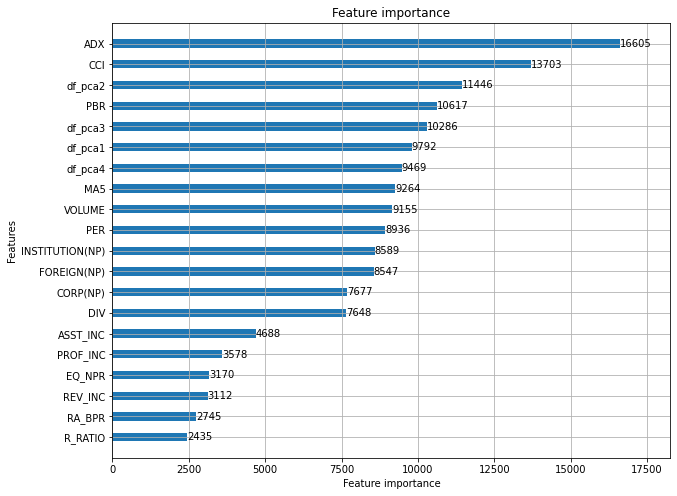

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(lgbm_wrapper, ax=ax,max_num_features=20,height=0.4 )

In [ ]:
df.to_csv('/content/drive/MyDrive/DART_project/df변수모음/최종df.csv')

In [ ]:
import numpy as np
X_features_LSTM = np.array(X_features).reshape(X_features.shape[0],X_features.shape[1],1)
labels_LSTM = np.array(labels)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_features_LSTM, labels_LSTM, test_size=0.2)

In [ ]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential
from keras import layers
from keras import models
from keras import optimizers

model = Sequential()
model.add(LSTM(units = 24, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
# #Adding second LSTM layer
#Adding Output layer
model.add(Dense(1))
#Compiling the RNN
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
model.fit(X_train, Y_train, epochs = 5, batch_size = 10, verbose=True)

Epoch 1/5
1476/1476 [==============================] - 17s 10ms/step - loss: 0.5969 - accuracy: 0.3673
Epoch 2/5
1476/1476 [==============================] - 12s 8ms/step - loss: 0.5654 - accuracy: 0.3438
Epoch 3/5
1476/1476 [==============================] - 10s 7ms/step - loss: 0.5626 - accuracy: 0.3476
Epoch 4/5
1476/1476 [==============================] - 9s 6ms/step - loss: 0.5612 - accuracy: 0.3394
Epoch 5/5
1476/1476 [==============================] - 13s 9ms/step - loss: 0.5592 - accuracy: 0.3457


In [ ]:
#샘플모델 예측

In [ ]:
 import pickle
 
 with open("/content/drive/MyDrive/DART_project/df만들기/final_df.pkl", "rb") as handle:
        df = pickle.load(handle)

In [ ]:
df.drop(['name','date','open', 'high', 'low', 'change','1w_yield','2w_yield','3w_yield','1m_yield'],axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_le = LabelEncoder()
df.industry = class_le.fit_transform(df.industry)

df['1m_yield_c'] = class_le.fit_transform(df['1m_yield_c'])
df['1w_yield_c'] = class_le.fit_transform(df['1w_yield_c'])
df['2w_yield_c'] = class_le.fit_transform(df['2w_yield_c'])
df['3w_yield_c'] = class_le.fit_transform(df['3w_yield_c'])


In [ ]:
lists = ['Volume', 'MA5', 'MA10', 'MA20', 'MA50', 'ADX', 'CCI', 'WILLR', 'RSI', 'asst_inc', 'rev_inc', 'prof_inc', 's_asst_inc', 'rev_bpr', 'eq_npr', 'ra_bpr', 'r_ratio', 'd_ratio', 'f_ratio', 'debt_r', 'asst_to', 'st_to']

for list1 in lists:
  for i in range(len(df)):
    df[list1][i] = (df[list1][i])
df = df.astype('int')


In [ ]:
df_3week = df.drop(['1m_yield_c','1w_yield_c','2w_yield_c'],axis=1)
df_1month= df.drop(['1w_yield_c','2w_yield_c','3w_yield_c'],axis=1)
df_1week = df.drop(['1m_yield_c','2w_yield_c','3w_yield_c'],axis=1)
df_2week = df.drop(['1m_yield_c','1w_yield_c','3w_yield_c'],axis=1)

In [ ]:
df_1week = df_1week.set_index('1w_yield_c')
df_1week = df_1week.reset_index()

In [ ]:
df_1week.drop(['MA5','MA10','MA50','WILLR','RSI','ra_bpr','r_ratio','asst_to','month_기사_count'],axis=1,inplace=True)

In [ ]:
df_1month.drop(['MA10', 'MA20', 'MA50','WILLR','RSI','d_ratio','month_기사_count','asst_to'],axis=1,inplace=True)

In [ ]:
df_1month

,industry,close,Volume,MA5,ADX,CCI,asst_inc,rev_inc,prof_inc,s_asst_inc,rev_bpr,eq_npr,ra_bpr,r_ratio,f_ratio,debt_r,st_to,1m_yield_c,week1_기사_키워드평균,week1_기사_긍부정평균,week1_기사_count,week2_기사_키워드평균,week2_기사_긍부정평균,week2_기사_count,week3_기사_키워드평균,week3_기사_긍부정평균,week3_기사_count,week4_기사_키워드평균,week4_기사_긍부정평균,week4_기사_count
0,1,15350,382063,14680,20,-59,-5,-29,-94,11,8,1,26,111,140,223,2,0,2,0,10,2,1,8,0,0,8,4,0,41
1,0,339000,153013,336500,13,105,0,0,71,218,7,1,9,167,103,68,1,1,10,1,34,7,0,43,7,1,58,14,1,57
2,0,11050,334027,10810,17,2,2,2,-118,58,4,0,-6,66,175,163,2,1,5,0,10,0,0,1,0,0,1,2,0,1
3,1,43115,291435,42874,13,-76,-9,-25,-36,257,10,6,7,111,89,253,7,0,5,0,15,0,0,0,3,0,10,12,0,8
4,0,57200,350878,57540,15,-54,0,2,29,258,7,1,23,122,149,96,1,4,2,0,26,3,1,23,-8,0,10,5,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0,272000,338015,270800,36,-20,0,-5,-75,227,1,0,0,206,93,72,1,5,11,0,41,13,1,81,20,1,125,19,1,83
3686,0,8120,1559395,7850,20,77,-3,5,-151,67,7,3,-10,64,174,158,1,4,0,0,1,2,0,6,1,0,13,2,0,26
3687,1,27400,407327,26840,29,3,0,0,-78,106,3,1,3,144,109,175,1,5,7,1,18,4,0,8,5,0,19,4,1,16
3688,1,48000,331957,48030,45,-71,0,-6,-92,207,1,0,1,172,68,47,5,4,0,0,6,3,0,2,9,0,6,0,0,4


In [ ]:
X_features_1week = df_1week.drop('1w_yield_c',axis=1)
y_label_1week = df_1week['1w_yield_c']


# X_features_2week = df.drop(['3w_yield','1m_yield','1w_yield','date','name','2w_yield_c','1w_yield_c','3w_yield_c','1m_yield_c','week1_기사_키워드평균','week1_기사_긍부정평균','week1_기사_count','week3_기사_키워드평균','week3_기사_긍부정평균','week3_기사_count','week4_기사_키워드평균','week4_기사_키워드평균','week4_기사_count','month_기사_count','week4_기사_긍부정평균'],axis=1)
# y_label_2week = df['2w_yield_c']

# X_features_3week = df.drop(['date','name','1w_yield','2w_yield','3w_yield_c','1w_yield_c','2w_yield_c','1m_yield_c','week1_기사_키워드평균','week1_기사_긍부정평균','week1_기사_count','week2_기사_키워드평균','week2_기사_긍부정평균','week2_기사_count','week4_기사_키워드평균','week4_기사_키워드평균','week4_기사_count','month_기사_count','week4_기사_긍부정평균'],axis=1)
# y_label_3week = df['3w_yield_c']


X_features_1month = df_1month.drop(['1m_yield_c'],axis=1)
y_label_1month = df_1month['1m_yield_c']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

X_features_1month[['week1_기사_키워드평균','week1_기사_긍부정평균', 'week1_기사_count', 'week2_기사_키워드평균', 'week2_기사_긍부정평균','week2_기사_count', 'week3_기사_키워드평균', 'week3_기사_긍부정평균', 'week3_기사_count','week4_기사_키워드평균', 'week4_기사_긍부정평균', 'week4_기사_count']] = mm_scaler.fit_transform(X_features_1month[['week1_기사_키워드평균','week1_기사_긍부정평균', 'week1_기사_count', 'week2_기사_키워드평균', 'week2_기사_긍부정평균','week2_기사_count', 'week3_기사_키워드평균', 'week3_기사_긍부정평균', 'week3_기사_count','week4_기사_키워드평균', 'week4_기사_긍부정평균', 'week4_기사_count']])
# X_features_1month = mm_scaler.fit_transform(X_features_1month)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_1month[['close', 'Volume', 'MA5', 'ADX', 'CCI', 'asst_inc','rev_inc', 'prof_inc', 's_asst_inc', 'rev_bpr', 'eq_npr', 'ra_bpr','r_ratio', 'f_ratio', 'debt_r', 'st_to']] = scaler.fit_transform(X_features_1month[['close', 'Volume', 'MA5', 'ADX', 'CCI', 'asst_inc','rev_inc', 'prof_inc', 's_asst_inc', 'rev_bpr', 'eq_npr', 'ra_bpr','r_ratio', 'f_ratio', 'debt_r', 'st_to']])
# x_test_norm = scaler.fit_transform(x_test)

# X_features_1week.asst_inc = np.log1p(X_features_1week.asst_inc)
# X_features_1week.debt_r = np.log1p(X_features_1week.debt_r)
# X_features_1week.prof_inc = np.log1p(X_features_1week.prof_inc)
# X_features_1week.s_asst_inc = np.log1p(X_features_1week.s_asst_inc)
# X_features_1week.CCI = np.log1p(X_features_1week.CCI)
# X_features_1week.rev_inc = np.log1p(X_features_1week.rev_inc)
# import numpy as np
# X_features_1month.close = np.log1p(X_features_1month.close)
# X_features_1month.Volume = np.log1p(X_features_1month.Volume)
# X_features_1month.MA20 = np.log1p(X_features_1month.MA5)
# X_features_1month.ADX = np.log1p(X_features_1month.ADX)
# X_features_1month.f_ratio = np.log1p(X_features_1month.f_ratio)
# X_features_1month.st_to = np.log1p(X_features_1month.st_to)



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X_features_1month, y_label_1month, test_size = 0.1, random_state = 156)

NameError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
#RandomForest 0.6721 
#샘플수가 적으므로 RandomForest에서 성과가 더 좋게나옴
warnings.filterwarnings('ignore')
rf_clf = RandomForestClassifier(random_state=142)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
pred_proba=rf_clf.predict_proba(X_test)[:,1]
accuracy = accuracy_score(y_test,pred)
print('rf 정확도:{0:.4f}'.format(accuracy))

rf 정확도:0.6721


In [ ]:
from lightgbm import LGBMClassifier
lgbm_wrapper = LGBMClassifier(n_estimators=300)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
preds_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

NameError: ignored

In [ ]:
#LightGBM 0.64
accuracy = accuracy_score(y_test,preds)
print('rf 정확도:{0:.4f}'.format(accuracy))

rf 정확도:0.6125
